##Exploration of how PAD-US (as-is) can be used with migration corridor information to assist in restoration and other management efforts/actions.

In [28]:
#Import needed packages
from io import BytesIO
from zipfile import ZipFile
import requests
import geopandas as gpd

#Allow matplotlib to show visualizations in the notebook
%matplotlib inline

AttributeError: module 'geopandas' has no attribute 'plot'

##### Import Corridor Data to GeoDataframes 
The next several code blocks shows how corridor data were imported into geodataframes using Python's GeoPandas 

In [2]:
#State of Wyoming data (zipped shapefiles) showing the extent, stopovers and bottlenecks for mule deer migration corridor for the Sublette herd.  This is the download URL.
sublette_url = 'https://wgfd.wyo.gov/WGFD/media/content/Wildlife/Geospatial/Big%20Game/MuleDeerMigrationCorridorComplex(Sublette).zip'

#Download zipfile 
r = requests.get(sublette_url)
z = ZipFile(BytesIO(r.content))
available_shp_files = [y for y in sorted(z.namelist()) for ending in ['shp'] if y.endswith(ending)]
z.extractall('data/')

In [3]:
#Shows available shapefiles within the zip file
print (available_shp_files)

['MuleDeerMigrationCorridorBottlenecksSublette.shp', 'MuleDeerMigrationCorridorStopoversSublette.shp', 'MuleDeerMigrationCorridorsSublette.shp']


In [4]:
#Read data from shapefiles into geopandas dataframes.  

#geospatial information on corridors used by the Sublette population 
deer_sublette_corridors = gpd.read_file('data/MuleDeerMigrationCorridorsSublette.shp')

#geospatial information on corridor bottlenecks for the Sublette population as defined by state of WY
deer_sublette_bottleneck = gpd.read_file('data/MuleDeerMigrationCorridorBottlenecksSublette.shp')

In [5]:
#Reproject corridor data to WGS84
mdeer_sublette_corridors = deer_sublette_corridors.to_crs({'init':'epsg:4326'})
mdeer_sublette_bottlenecks = deer_sublette_bottleneck.to_crs({'init':'epsg:4326'})

#show the dataframe to understand what data are available
mdeer_sublette_bottlenecks

,Acres,HERDNAME,Name,Shape_Area,Shape_Leng,geometry
0,560.36,Sublette,Fremont Lake,2.266245e+06,6789.687823,"POLYGON ((-109.837842064998 42.90646480341124,..."
1,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,POLYGON ((-109.9088392644179 42.99733013827631...
2,769.72,Sublette,Boulder Lake,3.112841e+06,9890.372406,POLYGON ((-109.7050102016812 42.83601307042731...
3,772.69,Sublette,New Fork Lake,3.125140e+06,10032.345444,"POLYGON ((-109.969197527838 43.08347192551762,..."
4,125.62,Sublette,Duck Creek,5.080774e+05,2527.003269,POLYGON ((-109.9521529570858 42.87273599212016...
5,362.84,Sublette,Trapper's Point,1.467520e+06,6314.822461,POLYGON ((-109.9939060678623 42.88280430173704...
6,484.45,Sublette,Daniel,1.959432e+06,8347.139414,POLYGON ((-110.0768054258186 42.90155805649331...


##### Import PADUS Data to GeoDataframes 
The next several code blocks shows how protected areas data were imported into geodataframes using Python's GeoPandas 

Note for now this works against a shapefile that was subset and transformed to WGS84 from the PADUS1_4 dataset. This will eventually work against the BIS spatial feature registry instead.

In [6]:
#Notes:
#downloaded PADUS1_4 from ScienceBase and reprojected it to WGS84 and selected only WY protected areas in ArcMap.  
#When doing that in GC2 and in Python the reprojection showed that it worked but failed to do anything
#=====================================================================================================
#Import WY PADUS into GeoPandas dataframe and set crs to WGS84 => epsg:4326
wy_padus = gpd.read_file('pad/wy_padus1_4com_wgs84.shp')
wy_padus.crs = {'init': 'epsg:4326'}

In [7]:
# Show what fields are included in PADUS
wy_padus.columns

Index(['Access', 'Access_Src', 'Agg_Src', 'Category', 'Comments', 'Date_Est',
       'Des_Tp', 'FeatureID', 'GAPCdDt', 'GAPCdSrc', 'GAP_Sts', 'GIS_Acres',
       'GIS_Src', 'IUCNCtDt', 'IUCNCtSrc', 'IUCN_Cat', 'Loc_Ds', 'Loc_Mang',
       'Loc_Nm', 'Loc_Own', 'Mang_Name', 'Mang_Type', 'Own_Name', 'Own_Type',
       'Source_PAI', 'Src_Date', 'State_Nm', 'Unit_Nm', 'WDPA_Cd', 'd_Access',
       'd_Category', 'd_Des_Tp', 'd_GAP_Sts', 'd_IUCN_Cat', 'd_Mang_Nam',
       'd_Mang_Typ', 'd_Own_Name', 'd_Own_Type', 'd_State_Nm', 'geometry'],
      dtype='object')

In [8]:
#Remove some unneeded fields from PADUS to help declutter for future tables and exploration... note that in future some of these fields may be needed.
remove_fields = ['Comments','Loc_Ds', 'GAPCdDt', 'GAP_Sts', 'GAPCdSrc', 'Des_Tp', 'Date_Est', 'Loc_Mang', 'Loc_Nm', 'Loc_Own', 'Mang_Name', 'Mang_Type', 'Own_Name', 'Own_Type', 'GIS_Acres', 'GIS_Src', 'IUCN_Cat', 'IUCNCtDt', 'IUCNCtSrc', 'Source_PAI', 'Src_Date', 'State_Nm', 'WDPA_Cd']
for field in remove_fields:
    del wy_padus[field]
    
wy_padus.columns

Index(['Access', 'Access_Src', 'Agg_Src', 'Category', 'FeatureID', 'Unit_Nm',
       'd_Access', 'd_Category', 'd_Des_Tp', 'd_GAP_Sts', 'd_IUCN_Cat',
       'd_Mang_Nam', 'd_Mang_Typ', 'd_Own_Name', 'd_Own_Type', 'd_State_Nm',
       'geometry'],
      dtype='object')

##### Explore overlap and gaps of protected areas with the Sublette herd's corridor

In [9]:
#selects and builds list of intersecting polygons where there are both corridor and protected areas
padus_sublette = []
for index, orig in wy_padus.iterrows():
    for index2, ref in mdeer_sublette_corridors.iterrows():      
        if ref['geometry'].intersects(orig['geometry']):
            pad_id =orig['FeatureID']
            padus_sublette.append({'geometry':ref['geometry'].intersection(orig['geometry']),'pad_id':pad_id})
            
#Create geodataframe from intersecting polygons
pad_sublette_inter = gpd.GeoDataFrame(padus_sublette, columns=['geometry','pad_id'], geometry='geometry')
pad_sublette_inter.crs = {'init': 'epsg:4326'}

#Note: this simple code was way to slow
#sublette_pad_intersect= gpd.overlay(wy_mdeer_sublette, padus_wy, how='intersection')


In [10]:
# Because Protected Areas have overlapping polygons we need to dissolve polygons to calculate total area of protected sublette corridor
pad_sublette_inter['diss'] = 1
#A buffer had to resolve be added to deal with invalid polygon issue
pad_sublette_inter['geometry']= pad_sublette_inter.buffer(0.00001)
dissolve_intersect = pad_sublette_inter.dissolve(by='diss')

combined map
blue= Migration cooridor of Sublette heard of mule deer with no protected area overlap
red = Migration cooridor of Sublette heard of mule deer with protected area overlap


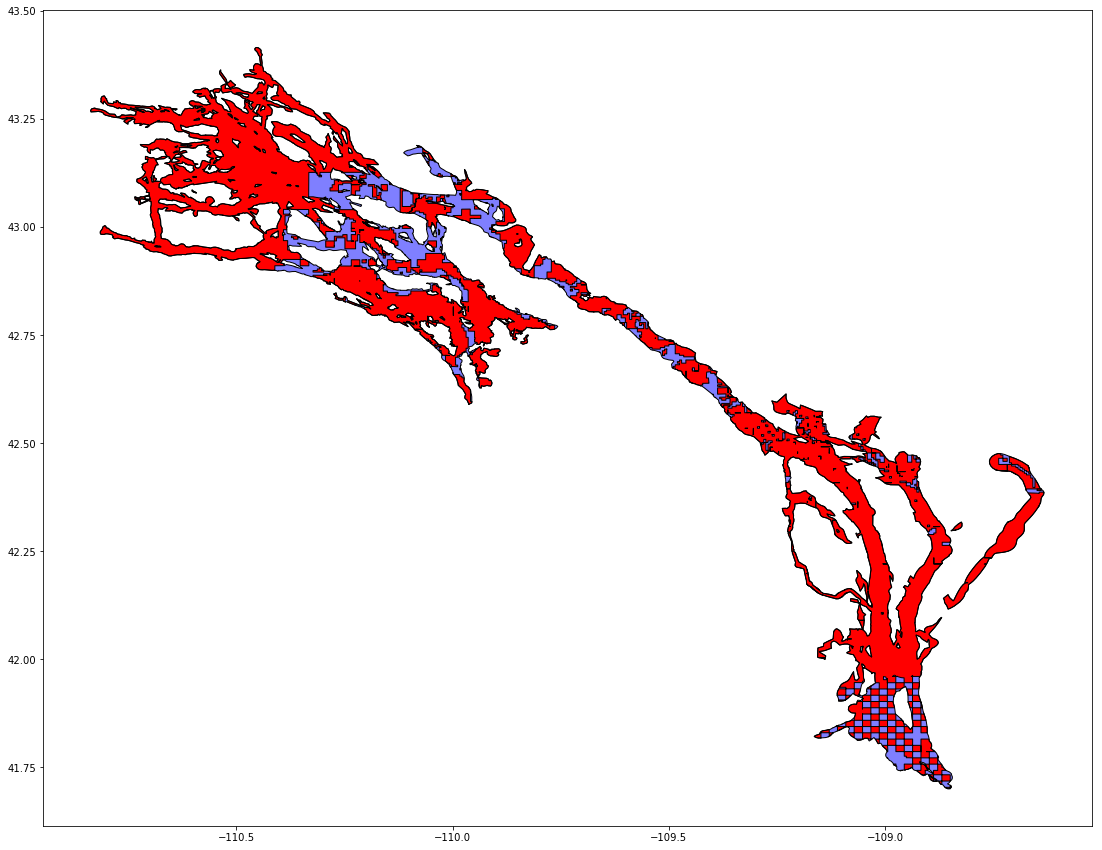

In [35]:
#Visualize entire mule deer corridor for the sublette population with the parts of the corridor that overlap protected areas
a = mdeer_sublette_corridors.plot(color='blue', figsize=(25,15))
dissolve_intersect.plot(ax=a, color='red', alpha=1)
print ('combined map')
print ('blue= Migration cooridor of Sublette heard of mule deer with no protected area overlap')
print ('red = Migration cooridor of Sublette heard of mule deer with protected area overlap')

Overlay of bottlenecks in the Sublette corridor (shown in blue) and protected areas within the corridor


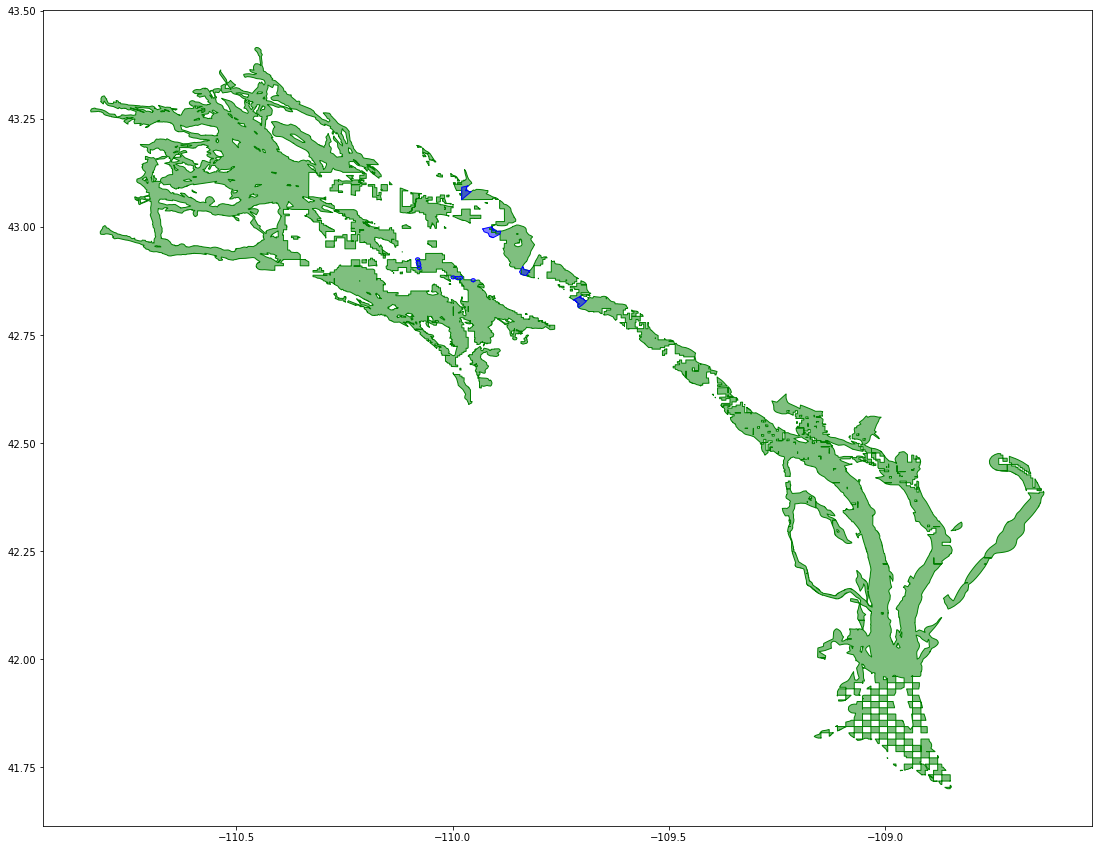

In [36]:
#Visualize where bottlenecks in the Sublette corridor overlap with protected areas
base = dissolve_intersect.plot(color='green',edgecolor='green', figsize=(25,15))
mdeer_sublette_bottlenecks.plot(ax=base, color='blue', edgecolor='blue', markersize=8, alpha = 0.5)
print ('Overlay of bottlenecks in the Sublette corridor (shown in blue) and protected areas within the corridor (green)')

In [14]:
#Create data to allow us to 'zoom in' and visualize which bottlenecks are protected
bottlenecks_no_pad = gpd.overlay(mdeer_sublette_bottlenecks, dissolve_intersect, how='difference')
bottlenecks_w_pad = gpd.overlay(mdeer_sublette_bottlenecks, pad_sublette_inter, how='intersection')

bottlenecks protected in green, bottlenecks not protect in blue


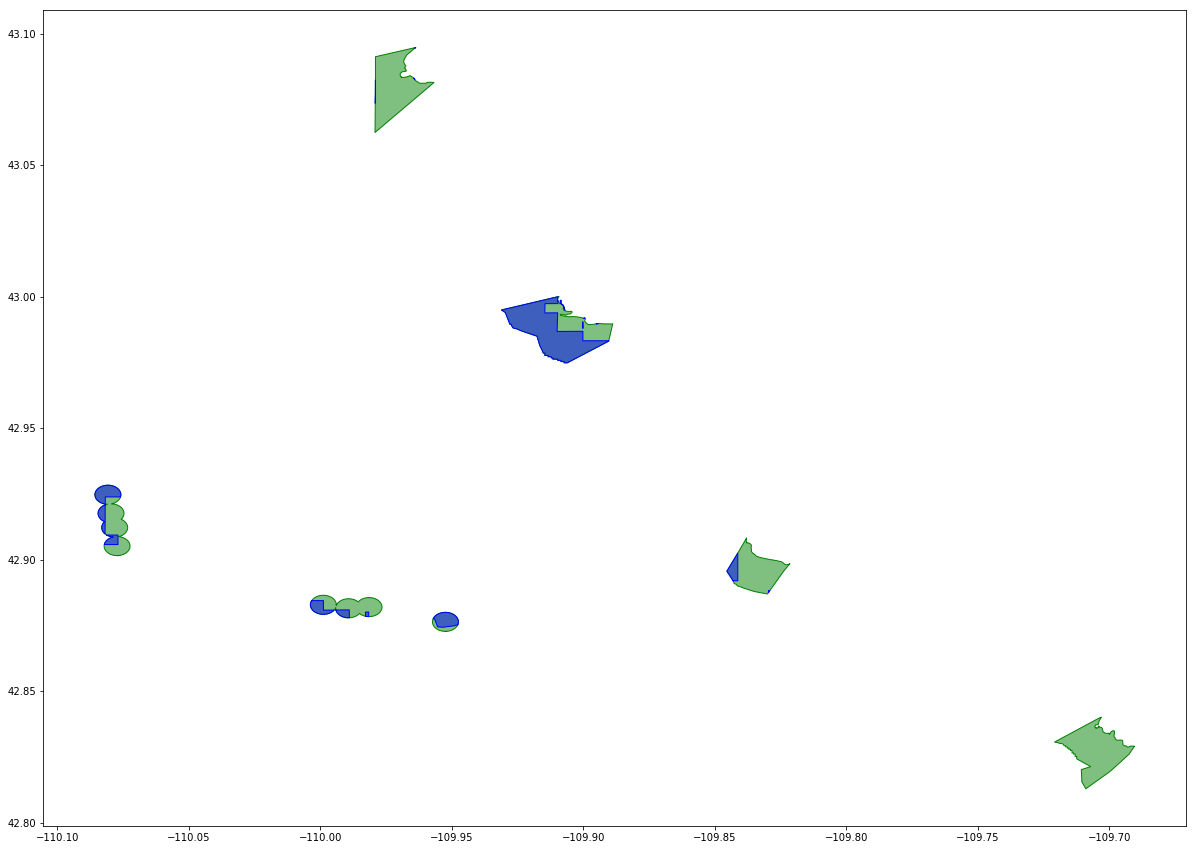

In [38]:
#Visualize bottlenecks of the sublette population and where these bottlenecks are 
base = mdeer_sublette_bottlenecks.plot(color='green', edgecolor='green',  figsize=(25,15))
bottlenecks_no_pad.plot(ax=base, color='blue', edgecolor='blue', markersize=8, alpha = 0.5)
print ('bottlenecks protected in green, bottlenecks not protect in blue')

In [ ]:
bottlenecks_w_pad

In [ ]:
sublette_area_alb = mdeer_sublette_corridors.to_crs({'init': 'epsg:5070'})
sublette_area_alb['area_km2']=sublette_area_alb['geometry'].area/10**6

dissolve_intersect.crs = {'init': 'epsg:4326'}
dissolve_intersect_alb = dissolve_intersect.to_crs({'init': 'epsg:5070'})
dissolve_intersect_alb['area_km2']=dissolve_intersect_alb['geometry'].area/10**6

In [ ]:
print ('Total area (km2) of sublette corridor: ' + str(int(sublette_area_alb['area_km2'].sum())))
print ('Area (km2) of sublette corridor intersecting protected areas: ' + str(int(dissolve_intersect_alb['area_km2'].sum())))

In [ ]:
### Had coordinate issues with data coming in from here... couldn't successfully reproject and it said 5070 but the other dataset when in 5070 did not line up

### Code that pulled back a subset of PADUS from SFR on GC2 instance
#### Only ran this once and then saved the data local to reduce unneeded load 
#-----------------------------------------------------------------------

#query spatial padus1_4 data for Wyoming from gc2
from bis2 import gc2 
import requests 
import geojson
url = gc2.baseURLs["sqlapi_datadistillery_bcb_beta"] 
table = "padus1_4" 
schema = "sfr" 
limit = 100 
offset = 0 
features = []
query_upid = "%s?q= select _id as id, access, access_src, agg_src, category, d_access, d_category, d_des_tp, d_gap_sts, d_iucn_cat, d_mang_nam, d_mang_typ, d_own_name, d_own_type, d_state_nm, (st_multi(st_makevalid(st_transform(the_geom,4326))))::(MultiPolygon,4326) AS geometry from %s.%s where state_nm='WY' limit %s offset %s" %  (url, schema, table, limit, offset)
page = requests.get(url=query_upid) 
page_json = geojson.loads(page.text) 
features += page_json['features']
while len(page_json['features']) != 0:
    offset += limit
    query_upid = "%s?q= select _id as id, access, access_src, agg_src, category, d_access, d_category, d_des_tp, d_gap_sts, d_iucn_cat, d_mang_nam, d_mang_typ, d_own_name, d_own_type, d_state_nm, (st_multi(st_makevalid(st_transform(the_geom,4326))))::(MultiPolygon,4326) AS geometry from %s.%s where state_nm='WY' limit %s offset %s" % (url, schema, table, limit, offset)
    page = requests.get(url=query_upid)
    page_json = geojson.loads(page.text)
    features += page_json['features']
#Import data into geopandas 
crs = {'init': 'epsg:4362'} 
padus_wy=gpd.GeoDataFrame.from_features(features, crs)
#Save data to geojson file 
padus_wy.to_file( 'padus_wy.geojson', driver='GeoJSON')